In [ ]:
!pip install -r requirements.txt

In [ ]:
pip install --upgrade jupyterlab ipympl

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from os import listdir
from os.path import splitext, isfile, isdir, getsize
from imagemanager import ImageManager
from processing import AstroImageProcessing
from scipy.signal import correlate2d
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
import streamlit.components.v1 as components

In [3]:
def load_speckle_images(image_files):
    """ Charge les images de tavelures à partir d'une liste de chemins de fichiers. """
    imager = ImageManager()
    im_per_column = 6
    tab =  [roi for roi in [AstroImageProcessing.find_roi(imager.read_image(file)) for file in image_files] if roi is not None]

    max_w = 0
    max_h = 0
    for im in tab:
        (h, w) = im.shape
        max_w = max(w, max_w)
        max_h = max(h, max_h)
        
    for index, im in enumerate(tab):
        tab[index] = AstroImageProcessing.resize_with_padding(im, max_w, max_h)
    show_images(tab)
    return tab

In [4]:
def show_images(images, maxperline=20, size = 12, max=None):
    if max!=None:
        limit = min(max, len(images))
    else:
        limit = len(images)
    if maxperline>limit:
        maxperline=limit
    fig, axs = plt.subplots((limit)//maxperline+1, maxperline)
    fig.set_figheight(int(limit/maxperline)*size)
    fig.set_figwidth(maxperline*size)

    for i in range(0,limit):
        axs[i//maxperline,i%maxperline].imshow(cv2.resize(images[i],(300,300)))
    plt.show()

def show_image_3d(image):

    x = np.arange(image.shape[1])
    y = np.arange(image.shape[0])
    x, y = np.meshgrid(x, y)

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')


    # Utiliser la valeur des pixels comme coordonnées Z
    z = image

    # Afficher la surface
    ax.plot_surface(x, y, z, cmap='gray')

    # Définir les libellés des axes
    ax.set_xlabel('Axe X')
    ax.set_ylabel('Axe Y')
    ax.set_zlabel('Valeur des pixels')
    ax.view_init(56, 134, 0)
    # Afficher le graphique
    plt.show()

In [5]:
def show_image(image, resize=None):
    if resize:
        plt.imshow(cv2.resize(image, resize))
    else:
        plt.imshow(image)
    
    
    

In [ ]:
image_files = []
dir = "images"
for file in listdir(dir):
    file_path = dir + '/' + file
    if isfile(file_path) and splitext(file_path)[1]=='.fit':
        image_files.append(file_path)
speckle_images = load_speckle_images(image_files)

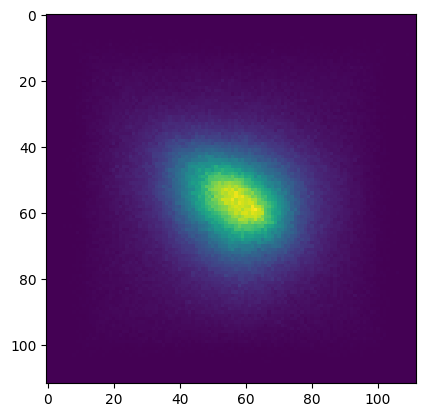

In [7]:
sum_images = AstroImageProcessing.sum_images(speckle_images)
show_image(sum_images)

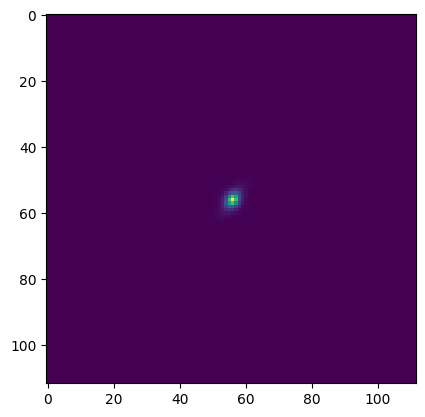

In [8]:
fourier = (AstroImageProcessing.fourier_transform(sum_images))
fourier_abs = np.absolute(fourier)
show_image(fourier_abs)

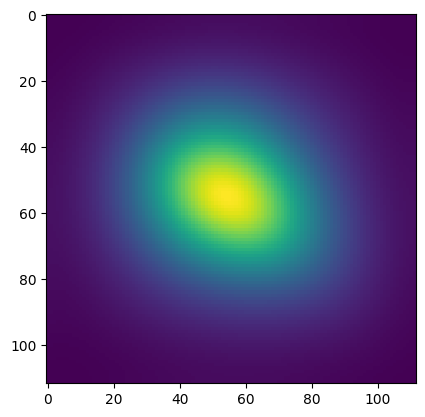

In [9]:
image = np.absolute(AstroImageProcessing.fourier_transform(np.square(fourier)))
show_image(image)

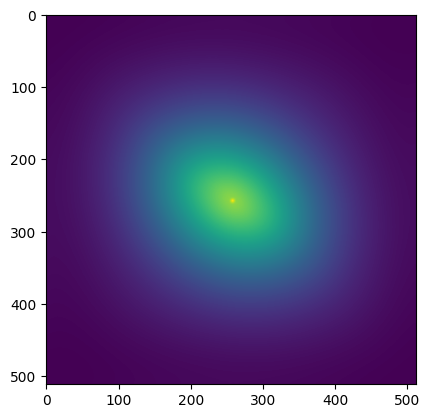

In [10]:
result=[AstroImageProcessing.crosscorr(i,i) for i in speckle_images]
sum_autocorrelation = AstroImageProcessing.sum_images(result)
show_image(cv2.resize(sum_autocorrelation,(512,512)))


In [11]:
def apply_mean_mask_subtraction(image, k_size=3):
    """
    Applique une soustraction de masque moyen à l'image avec des noyaux croissants.

    :param image: Image d'entrée (autocorrelogramme).
    :param max_kernel_size: Taille maximale du noyau carré (doit être impair).
    :return: Image traitée.
    """
    processed_image = image.copy()
    # Créer un noyau moyen
    kernel = np.ones((k_size, k_size), np.float32) / (k_size * k_size)

    # Appliquer le filtre moyenneur
    mean_filtered = cv2.filter2D(image, -1, kernel)

    # Soustraire le résultat filtré de l'image originale
    processed_image = cv2.subtract(processed_image, mean_filtered)

    return processed_image

In [ ]:
result = []
for i in range(0,9):
        fig = plt.figure(figsize=(8, 6))
        im = apply_mean_mask_subtraction(sum_autocorrelation   ,3+i*2)
        im = (im*65535/im.max()).astype(np.uint16)
        result.append(im)
        #plt.show()
# Calcul de la valeur moyenne des pixels
show_images(result,3,50)


C:\Users\eniquet\AppData\Local\Temp\ipykernel_23236\2995695662.py:4: RuntimeWarning: invalid value encountered in log
  show_image_3d(np.log(im + 1))


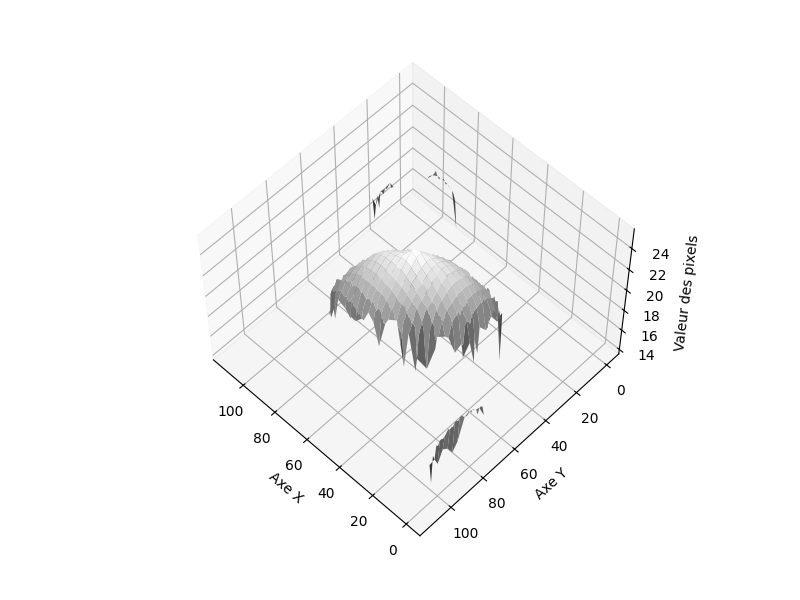

In [24]:
%matplotlib widget
im = apply_mean_mask_subtraction(sum_autocorrelation   ,3+4*2)

show_image_3d(np.log(im + 1))